## Environment Setup and Imports

### Library imports

In [0]:
import pandas as pd
import csv
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, MaxPool1D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import h5py
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf
from tensorflow.python.client import device_lib

import gensim
from gensim.models import KeyedVectors

from adabound import AdaBound


In [0]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 1000)

In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.test.gpu_device_name()

'/device:GPU:0'

### Download pubmed vectors

In [5]:
!wget http://evexdb.org/pmresources/vec-space-models/PubMed-w2v.bin

--2019-08-20 12:01:25--  http://evexdb.org/pmresources/vec-space-models/PubMed-w2v.bin
Resolving evexdb.org (evexdb.org)... 130.232.253.44
Connecting to evexdb.org (evexdb.org)|130.232.253.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1909156308 (1.8G) [application/octet-stream]
Saving to: ‘PubMed-w2v.bin’

PubMed-w2v.bin        0%[                    ]   6.58M  1.03MB/s    eta 34m 45s^C


#### Load PubMed vector

In [0]:
path = "PubMed-w2v.bin"

modelW2v = KeyedVectors.load_word2vec_format(path, binary = True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
len(modelW2v.vocab.keys())

2351706

### Loading and Merging Data

In [6]:
critical_df = pd.read_csv("critical-findings-sample-data-20180601-20180901.csv")
critical_df.head()

Modality           Critical_Finding                        Category                                               Data
0       CT  Complete Critical Finding  Significant Vascular Pathology  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
1       CT  Complete Critical Finding  Significant Vascular Pathology  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
2       CT  Complete Critical Finding  Significant Vascular Pathology  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
3       CT  Complete Critical Finding            Acute Vascular Event  HISTORY: left sided weakness<br /><br />TECHNI...
4       CT  Complete Critical Finding            Acute Vascular Event  HISTORY: left sided weakness<br /><br />TECHNI...

In [7]:
non_critical_df = pd.read_csv("non-critical-findings-sample-data-20180601-20180901.csv")
non_critical_df.head()

Modality Critical_Finding  Category                                               Data
0       CR             None       NaN  STUDY:   X-RAY - LEFT HAND<br /><br />REASON F...
1       US             None       NaN  STUDY:   VENOUS DOPPLER ULTRASOUND -LEFT UPPER...
2       CR             None       NaN  XR Chest 1 View<br /><br />INDICATION: for com...
3       CR             None       NaN  STUDY:   X-RAY CHEST<br /><br />REASON FOR EXA...
4       US             None       NaN  STUDY:   VENOUS DOPPLER ULTRASOUND - LEFT LOWE...

In [8]:
critical_and_non_critical_df = pd.concat([critical_df, non_critical_df], axis=0).reset_index(drop=True)
critical_and_non_critical_df.head()

Modality           Critical_Finding                        Category                                               Data
0       CT  Complete Critical Finding  Significant Vascular Pathology  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
1       CT  Complete Critical Finding  Significant Vascular Pathology  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
2       CT  Complete Critical Finding  Significant Vascular Pathology  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
3       CT  Complete Critical Finding            Acute Vascular Event  HISTORY: left sided weakness<br /><br />TECHNI...
4       CT  Complete Critical Finding            Acute Vascular Event  HISTORY: left sided weakness<br /><br />TECHNI...

## Cleaning Data

In [9]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.str.replace("<br />", " ").str.lower()
critical_and_non_critical_df.head()

Modality           Critical_Finding                        Category                                               Data
0       CT  Complete Critical Finding  Significant Vascular Pathology  study:   ct chest with contrast  reason for ex...
1       CT  Complete Critical Finding  Significant Vascular Pathology  study:   ct chest with contrast  reason for ex...
2       CT  Complete Critical Finding  Significant Vascular Pathology  study:   ct chest with contrast  reason for ex...
3       CT  Complete Critical Finding            Acute Vascular Event  history: left sided weakness  technique: ct he...
4       CT  Complete Critical Finding            Acute Vascular Event  history: left sided weakness  technique: ct he...

In [0]:
def remove_punctuation(text):
    
    translator = str.maketrans('', '', string.punctuation + "0123456789")
    
    return text.translate(translator)

In [11]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(remove_punctuation)
critical_and_non_critical_df.head()

Modality           Critical_Finding                        Category                                               Data
0       CT  Complete Critical Finding  Significant Vascular Pathology  study   ct chest with contrast  reason for exa...
1       CT  Complete Critical Finding  Significant Vascular Pathology  study   ct chest with contrast  reason for exa...
2       CT  Complete Critical Finding  Significant Vascular Pathology  study   ct chest with contrast  reason for exa...
3       CT  Complete Critical Finding            Acute Vascular Event  history left sided weakness  technique ct head...
4       CT  Complete Critical Finding            Acute Vascular Event  history left sided weakness  technique ct head...

In [12]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [0]:
def stop_words(text) :
    
    text = [word for word in text.split() if word not in stopwords.words("english")]
    
    return " ".join(text)

In [0]:
# critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(stop_words)
# critical_and_non_critical_df.head()

In [0]:
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):    
    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [16]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(lemmatizing)
critical_and_non_critical_df.head()

Modality           Critical_Finding                        Category                                               Data
0       CT  Complete Critical Finding  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
1       CT  Complete Critical Finding  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
2       CT  Complete Critical Finding  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
3       CT  Complete Critical Finding            Acute Vascular Event  history left sided weakness technique ct head ...
4       CT  Complete Critical Finding            Acute Vascular Event  history left sided weakness technique ct head ...

In [0]:
def remove_single_length_words(text) :
    
    text = [word for word in word_tokenize(text) if len(word) > 1]
    
    return " ".join(text)

In [18]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(remove_single_length_words)
critical_and_non_critical_df.head()

Modality           Critical_Finding                        Category                                               Data
0       CT  Complete Critical Finding  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
1       CT  Complete Critical Finding  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
2       CT  Complete Critical Finding  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
3       CT  Complete Critical Finding            Acute Vascular Event  history left sided weakness technique ct head ...
4       CT  Complete Critical Finding            Acute Vascular Event  history left sided weakness technique ct head ...

In [19]:
critical_and_non_critical_df.Critical_Finding.replace(["None", "Complete Critical Finding", "Complete Physician Decline"], [0, 1, 1], inplace=True)
critical_and_non_critical_df.head(15)

Modality  Critical_Finding                        Category                                               Data
0          CT                 1  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
1          CT                 1  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
2          CT                 1  Significant Vascular Pathology  study ct chest with contrast reason for exam m...
3          CT                 1            Acute Vascular Event  history left sided weakness technique ct head ...
4          CT                 1            Acute Vascular Event  history left sided weakness technique ct head ...
5          CT                 1      Immediate Surgical Medical  study ct abdomen and pelvis without contrast r...
6          CT                 1      Immediate Surgical Medical  study ct abdomen and pelvis without contrast r...
7          CT                 1      Immediate Surgical Medical  study ct abdomen and pelvis without contrast r...
8          CR                 1              Unsuspected Injury  study xray chest reason for exam male year old...
9          CR                 1              Unsuspected Injury  study xray chest reason for exam male year old...
10         CR                 1              Unsuspected Injury  study xray chest reason for exam male year old...
11  RG,CT,CTA                 1                 Cancer/Neoplasm  study cta chest reason for exam male year old ...
12  RG,CT,CTA                 1                 Cancer/Neoplasm  study cta chest reason for exam male year old ...
13  RG,CT,CTA                 1                 Cancer/Neoplasm  study cta chest reason for exam male year old ...
14         CT                 1            Acute Vascular Event  study ct abdomen and pelvis with contrast reas...

In [20]:
critical_and_non_critical_df.shape

(1000, 4)

In [0]:
words_count = {}

def count_words(text) :
    
    for word in word_tokenize(text) :
        if word not in words_count.keys() :
            words_count[word] = 1
        else :
            words_count[word] += 1


In [22]:
critical_and_non_critical_df.Data.apply(count_words)
sorted(words_count.items(), reverse=True, key=lambda kv : (kv[1], kv[0]))

[('the', 8798),
 ('normal', 5774),
 ('of', 5500),
 ('is', 4497),
 ('and', 4446),
 ('there', 3754),
 ('no', 2339),
 ('are', 1892),
 ('right', 1800),
 ('with', 1777),
 ('for', 1742),
 ('visualized', 1716),
 ('left', 1623),
 ('in', 1499),
 ('technique', 1443),
 ('ct', 1359),
 ('finding', 1231),
 ('contrast', 1209),
 ('to', 1090),
 ('were', 1032),
 ('impression', 973),
 ('image', 952),
 ('comparison', 938),
 ('study', 924),
 ('without', 894),
 ('or', 884),
 ('chest', 829),
 ('exam', 824),
 ('old', 822),
 ('cm', 793),
 ('artery', 783),
 ('reason', 777),
 ('bilateral', 763),
 ('year', 752),
 ('this', 741),
 ('by', 741),
 ('pulmonary', 647),
 ('at', 641),
 ('mild', 629),
 ('small', 616),
 ('wa', 603),
 ('acute', 598),
 ('none', 593),
 ('within', 583),
 ('lung', 574),
 ('tissue', 557),
 ('soft', 552),
 ('structure', 551),
 ('dose', 548),
 ('optimization', 547),
 ('used', 540),
 ('change', 540),
 ('abdomen', 538),
 ('demonstrated', 514),
 ('individualized', 486),
 ('upper', 479),
 ('on', 476),


### Getting word embeddings from pubmed

In [0]:
# word_embeddings = {}
# non_pubmed_words = {}
# # embedding_matrix = np.zeros( (len(words_count) + 1, 300) )
# for i, word in enumerate(words_count.keys()) :
#     if word in modelW2v.vocab.keys() :
#         word_embeddings[word] = modelW2v.get_vector(word)
# #         embedding_matrix[i] = word_embeddings[word]
#     else :
#         non_pubmed_words[word] = words_count[word]

In [0]:
# f = open('word_embeddings_pubmed.pkl', 'wb')
# pickle.dump(word_embeddings, f)
# f.close()

In [0]:
f = open('word_embeddings_pubmed.pkl', 'rb')
word_embeddings = pickle.load(f)
f.close()

In [26]:
word_embeddings

{'study': array([ 0.04481507,  0.15758407, -0.1443074 , -0.06640462,  0.01997742,
        -0.5372244 , -0.03024485, -0.01331234,  0.05328454,  0.01299717,
        -0.08778799,  0.051862  ,  0.04789511, -0.18925047,  0.21735312,
         0.01230495, -0.28944078, -0.23965394,  0.28724194, -0.22478396,
         0.02304844,  0.04416788,  0.12672825,  0.34206378, -0.16798745,
        -0.19593638,  0.10210444, -0.11288368, -0.07817175,  0.17210619,
         0.33596414,  0.13126808, -0.43068218,  0.03126198,  0.20920604,
         0.11510825,  0.3057404 ,  0.2024474 , -0.03321016,  0.27568257,
         0.318984  ,  0.27372202,  0.27534765,  0.24324875,  0.29330486,
        -0.08558797,  0.25207278, -0.20371689,  0.08056618,  0.20916778,
        -0.29821557,  0.14098498, -0.24292526,  0.08378823,  0.06700475,
        -0.03411394, -0.0859677 , -0.37681004,  0.03216701,  0.1761275 ,
         0.10930277,  0.06291796, -0.01507367, -0.01371297, -0.14377058,
        -0.17001809,  0.01197486,  0.23189

In [0]:
# sorted(non_pubmed_words.items(), reverse=True, key=lambda kv : (kv[1], kv[0]))

In [54]:
critical_and_non_critical_df = critical_and_non_critical_df.sample(frac=1).reset_index(drop=True)
critical_and_non_critical_df.head(15)

Modality  Critical_Finding              Category                                               Data
0        MR                 1       Cancer/Neoplasm  study mri cervical spine without contrast reas...
1        CR                 0                   NaN  study xray chest reason for exam male year old...
2        CT                 0                   NaN  study ct abdomen and pelvis with contrast reas...
3        CT                 1  Acute Vascular Event  history weakness jch ctdi dlp ferguson ct scan...
4        MR                 1       Cancer/Neoplasm  study mri thoracic spine without contrast reas...
5        CR                 0                   NaN  study xray right foot clinical female year old...
6        US                 1  Acute Vascular Event  study arterial doppler ultrasound left lower e...
7        CT                 0                   NaN  study ct abdomen and pelvis with contrast reas...
8        CT                 1       Cancer/Neoplasm  study ct abdomen and pelvis with contrast reas...
9        CT                 1                 Other  study ct abdomen and pelvis with contrast reas...
10       CR                 0                   NaN  study xray chest and abdomen reason for exam m...
11       CR                 0                   NaN  study xray chest reason for exam female year o...
12       CT                 0                   NaN  study ct brain without contrast reason for exa...
13       MR                 1  Acute Vascular Event  study mri brain without contrast reason for ex...
14       CT                 0                   NaN  study ct abdomen and pelvis without contrast r...

### Getting sentence vectors

In [0]:
pubmed_sent_vectors = []

def vectorize_sentence(text) :
    
    sen_vec = np.zeros(200)
    for word in text.split() :
        if word in word_embeddings.keys() :
            sen_vec += word_embeddings[word]
    
    pubmed_sent_vectors.append(sen_vec)

In [56]:
critical_and_non_critical_df.Data.apply(vectorize_sentence)
print()

In [57]:
pubmed_embedding_matrix = np.array(pubmed_sent_vectors)
pubmed_embedding_matrix.shape

(1000, 200)

In [0]:
# combined_tfidf_pubmed_embed = np.concatenate( (tfidf_array, pubmed_embedding_matrix), axis=1 )
# combined_tfidf_pubmed_embed.shape

### Scaling the data

In [59]:
scaler = StandardScaler()

combined_tfidf_pubmed_embed_scaled = scaler.fit_transform(pubmed_embedding_matrix)
combined_tfidf_pubmed_embed_scaled.shape

(1000, 200)

### ML Modeling

#### Logistic Regression

In [60]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

lreg_embed = LogisticRegression()
lreg_embed.fit(xtrain_embed, ytrain) # training the model

prediction = lreg_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8833333333333333

#### RandomForest Classifier

In [61]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

rfr_embed = RandomForestClassifier()
rfr_embed.fit(xtrain_embed, ytrain) # training the model

prediction = rfr_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.89

#### SVC

In [65]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

svc_tfidf = SVC(C=1.0, kernel='linear', degree=3, probability=True)
svc_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = svc_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9233333333333333

#### MLP Classifier

In [66]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

mlp_clf_tfidf = MLPClassifier([1000, 500, 100], learning_rate_init=0.01, learning_rate='adaptive')
mlp_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = mlp_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.8766666666666667

#### AdaBoost Classifier

In [67]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

ada_boost_tfidf = AdaBoostClassifier(n_estimators=3000, learning_rate=0.1)
ada_boost_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = ada_boost_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9233333333333333

#### Bagging Classifier

In [68]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

bag_clf_tfidf = BaggingClassifier(n_estimators=3000, n_jobs=-1)
bag_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = bag_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.925

#### ExtraTrees Classifier

In [69]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

extra_trees_clf_tfidf = ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, )
extra_trees_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = extra_trees_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.965

#### GradientBoosting Classifier

In [70]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_pubmed_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

grd_boost_clf_tfidf = GradientBoostingClassifier(n_estimators=3000)
grd_boost_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = grd_boost_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9133333333333333

### Cleaning and transforming for RNN

In [0]:
tokenizer = Tokenizer(num_words=3000)
texts = np.asarray([ x for x in critical_and_non_critical_df.Data ])
tokenizer.fit_on_texts(texts)

In [0]:
labels = np.asarray([ x for x in critical_and_non_critical_df.Critical_Finding ])

In [0]:
sequences = np.asarray(tokenizer.texts_to_sequences(texts))
sequences = pad_sequences(sequences, maxlen=100)
type(sequences)

numpy.ndarray

In [0]:
word_index = tokenizer.word_index

In [0]:
embedding_matrix = np.zeros( (len(word_index) + 1, 200) )
for word, i in word_index.items() :
  if word in word_embeddings.keys() :
    embedding_matrix[ i ] = np.array(word_embeddings[word])

In [0]:
embedding_matrix.shape

(3269, 200)

### DL Modeling

#### Creating the model

In [0]:
def rnn_model():
  
  model = Sequential()
  model.add(Embedding(input_dim=len(word_index) + 1, output_dim=200, weights=[embedding_matrix], mask_zero=False, trainable=True))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(60)))
  model.add(Dropout(0.5))
  # model.add(Dense(32, activation='relu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  
  optm = AdaBound(lr=1e-03,
                final_lr=0.1,
                gamma=1e-03,
                weight_decay=0.,
                amsbound=False)

  model.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
  return model

In [0]:
rnn_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, None, 200)         653800    
_________________________________________________________________
dropout_103 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 120)               125280    
_________________________________________________________________
dropout_104 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 121       
Total params: 779,201
Trainable params: 779,201
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)

estimator = KerasClassifier(build_fn=rnn_model, epochs=110, batch_size=200, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
early_stopping_monitor = EarlyStopping(patience=3)
history = estimator.fit(X_train, y_train, validation_split=0.10)

Train on 810 samples, validate on 90 samples
Epoch 1/110
810/810 [==============================] - 21s 26ms/step - loss: 0.6828 - acc: 0.5654 - val_loss: 0.6439 - val_acc: 0.6778
Epoch 2/110
810/810 [==============================] - 2s 2ms/step - loss: 0.6411 - acc: 0.6815 - val_loss: 0.6111 - val_acc: 0.7444
Epoch 3/110
810/810 [==============================] - 2s 3ms/step - loss: 0.5939 - acc: 0.7086 - val_loss: 0.5836 - val_acc: 0.7444
Epoch 4/110
810/810 [==============================] - 2s 2ms/step - loss: 0.5683 - acc: 0.7321 - val_loss: 0.5604 - val_acc: 0.7444
Epoch 5/110
810/810 [==============================] - 2s 2ms/step - loss: 0.5372 - acc: 0.7519 - val_loss: 0.5402 - val_acc: 0.7444
Epoch 6/110
810/810 [==============================] - 2s 2ms/step - loss: 0.5105 - acc: 0.7383 - val_loss: 0.5140 - val_acc: 0.8000
Epoch 7/110
810/810 [==============================] - 2s 3ms/step - loss: 0.4726 - acc: 0.7654 - val_loss: 0.4544 - val_acc: 0.8000
Epoch 8/110
810/810 [=

#### Evaluating the model

In [0]:
estimator.score(X_test, y_test)

100/100 [==============================] - 0s 771us/step


0.9200000166893005

#### Plotting the accuracy and loss graph

In [0]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

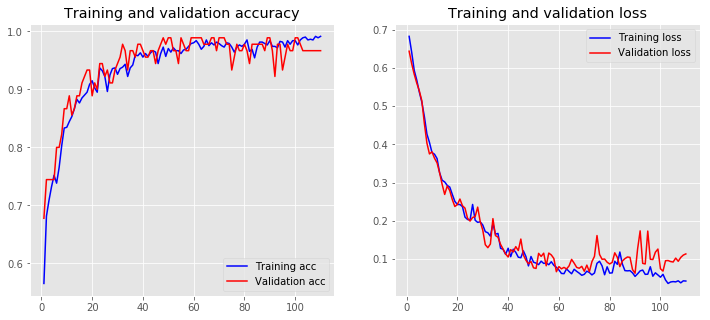

In [0]:
plot_history(history)